# Abstract

__This project aims to predict learners' exam performance by analyzing demographic and academic factors such as gender, ethnicity, parental level of education, their math, reading and writing scores. Using a multilinear regression model, I developed the model to forecast exam outcomes. The dataset was preprocessed for accuracy and the model was evaluated using the R-squared and Mean Absolute Error metrics. Results provide valuable insights into the impact of each factor on the performance, helping the educators to identify learners who are at high risk of failing so that effective measures can be put in place.__

# Importing libraries

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from lazypredict.Supervised import LazyClassifier,LazyRegressor
%matplotlib inline

# Importing the dataset

In [44]:
df=pd.read_csv('exams.csv')

In [45]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


# Exploring the data

In [46]:
#finding the unique ethnicities present among learners
df['race/ethnicity'].unique()

array(['group D', 'group B', 'group C', 'group E', 'group A'],
      dtype=object)

In [47]:
# Looking at the size of the dataset
df.shape

(1000, 8)

In [48]:
#Checking for misssing values
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [49]:
#Checking for educational levels of the learners' parents
df['parental level of education'].unique()

array(['some college', "associate's degree", 'some high school',
       "bachelor's degree", "master's degree", 'high school'],
      dtype=object)

In [50]:
#Checking for types of lunch learners have at school
df['lunch'].unique()

array(['standard', 'free/reduced'], dtype=object)

In [51]:
#Checking for the number of learners in each race
df['race/ethnicity'].value_counts()

group C    323
group D    257
group B    198
group E    143
group A     79
Name: race/ethnicity, dtype: int64

In [52]:
#Checking the number of learners in both genders
df['gender'].value_counts()

male      508
female    492
Name: gender, dtype: int64

In [53]:
#checking the average math score of each race group
race_score=df.groupby('race/ethnicity')['math score'].mean()
race_score

race/ethnicity
group A   65.70
group B   64.07
group C   65.51
group D   68.88
group E   77.43
Name: math score, dtype: float64

In [54]:
# Check for the math average math score of each gender in each race group
df.groupby(['gender','race/ethnicity'])['math score'].mean()

gender  race/ethnicity
female  group A          62.95
        group B          62.27
        group C          63.02
        group D          63.84
        group E          75.21
male    group A          68.66
        group B          66.42
        group C          67.70
        group D          73.16
        group E          79.55
Name: math score, dtype: float64

# Visualizing the data

Text(0.5, 1.0, 'Gender math score distribution')

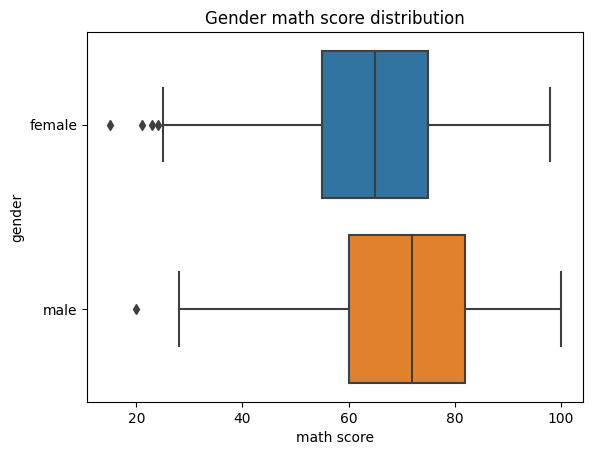

In [55]:
# ploting a boxplot to see the distribution of Math scores in both genders
sb.boxplot(x='math score',y='gender',data=df)
plt.title('Gender math score distribution')

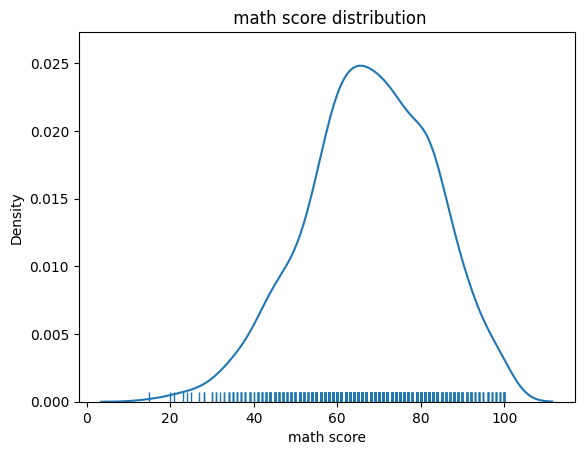

In [56]:
# ploting a distribution plot to see how math scores of all learners are distributed
sb.distplot(df['math score'],hist=False,rug=True)
plt.title(' math score distribution');

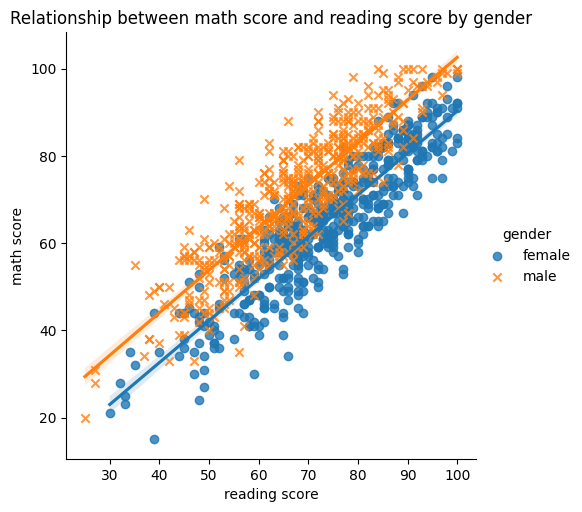

In [57]:
# Ploting a scatter plot to see the relationship between math scores and reading scores
sb.lmplot(x='reading score',y='math score',data=df,fit_reg=True,hue='gender',markers=['o','x'])
plt.title('Relationship between math score and reading score by gender');

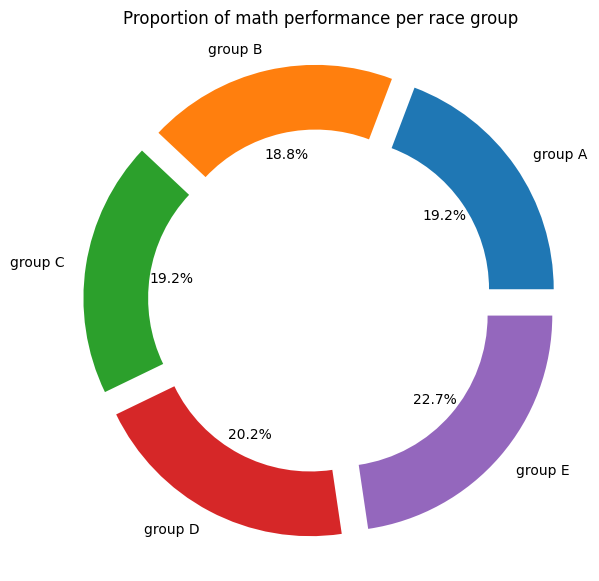

In [58]:
plt.figure(figsize=(7,7))
explode=[0.1,0.1,0.1,0.1,0.1]
plt.pie(race_score,labels=race_score.index,autopct='%1.1f%%',explode=explode,wedgeprops={'width':0.3})
plt.title('Proportion of math performance per race group');

# Data Preprocessing

In [44]:
# Transforming the datatypes of catagorical variables into numeric values
LE=LabelEncoder()


In [45]:
LE

LabelEncoder()

In [46]:
df['Gender']=LE.fit_transform(df['gender'])
df['Race/Ethnicity']=LE.fit_transform(df['race/ethnicity'])
df['Parental Level of Education']=LE.fit_transform(df['parental level of education'])
df['Lunch']=LE.fit_transform(df['lunch'])
df['Test Preparation Course']=LE.fit_transform(df['test preparation course'])

In [47]:
# Removing old unprocessed variables
df.drop('gender',axis=1,inplace=True)
df.drop('race/ethnicity',axis=1,inplace=True)
df.drop('parental level of education',axis=1,inplace=True)
df.drop('lunch',axis=1,inplace=True)
df.drop('test preparation course',axis=1,inplace=True)

In [48]:
df.head()

,math score,reading score,writing score,Gender,Race/Ethnicity,Parental Level of Education,Lunch,Test Preparation Course
0,59,70,78,0,3,4,1,0
1,96,93,87,1,3,0,1,1
2,57,76,77,0,3,4,0,1
3,70,70,63,1,1,4,0,1
4,83,85,86,0,3,0,1,1


# Model building

In [55]:
# Separating output varible from predictor variables
x=df.drop('math score',axis=1)
y=df['math score']

In [56]:
# Cross_validation of the model using Holdout approach or train test split
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.25,random_state=0)

In [57]:
train_x.shape,train_y.shape

((750, 7), (750,))

In [58]:
# Normalizing the dataset
Scaler=StandardScaler()

In [59]:
Scaler

StandardScaler()

In [60]:
train_x=Scaler.fit_transform(train_x)
test_x=Scaler.fit_transform(test_x)

In [61]:
#defining the type of the model
Model=LinearRegression()

In [62]:
Model

LinearRegression()

In [63]:
# Fitting the model
Model.fit(train_x,train_y)

LinearRegression()

In [64]:
# Predicting from the model
y_pred=Model.predict(test_x)

In [65]:
print(y_pred)

[ 87.17322315  85.14396103  45.20852127  55.21757098  60.24909227
  63.72995807  71.1021049   74.77832783  47.53947443  74.2864756
  84.19927844  78.29789134  65.46322298  58.43849372  70.66221992
  57.73954266  70.59108364  69.31957718  57.90233962  68.76757166
  70.04852629  55.3643074   83.14390108  52.96587869  67.94052015
  73.82195889  75.94687967  50.98921406  71.56527614  97.8856143
  75.35141629  56.61812884  65.70327293  90.76837027  90.82933563
  56.40474226  42.31321794  68.53872525  85.08930318  65.97107085
  59.4728108   74.82454038  58.95804414  54.11874585  75.9090263
  84.70132458  76.05576238  62.30063536  54.05045823  58.31994041
  75.36189896  57.13369137  50.47730008  70.59792099  65.48735295
  70.70179784  71.78760946  79.91221053  89.54459179  54.41159919
  65.39200525  99.95203787  87.42078617  64.50176674  67.60982965
  90.84348226  78.06131454  68.92059905  61.31048239  80.75422074
  75.59816723  65.18412709  45.09484937  79.56399921  78.61017941
  84.76563972

In [72]:
Model.score(train_x,train_y)

0.8673637564837677

# Using Statsmodels

In [66]:
x=sm.add_constant(x)

In [67]:
model=sm.OLS(y,x)

In [68]:
Results=model.fit()

In [69]:
print(Results)

In [70]:
Results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             math score   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     941.9
Date:                Fri, 25 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:22:04   Log-Likelihood:                -3125.9
No. Observations:                1000   AIC:                             6268.
Df Residuals:                     992   BIC:                             6307.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -12.1779      1.156    -10.532      0.000     -14.447      -9.909
reading score                   0.3026      0.042      7.232      0.000       0.220       0.385
writing score                   0.6497      0.042     15.527      0.000       0.568       0.732
Gender                         13.0399      0.378     34.533      0.000      12.299      13.781
Race/Ethnicity                  0.8616      0.157      5.482      0.000       0.553       1.170
Parental Level of Education    -0.0836      0.099     -0.841      0.401      -0.279       0.112
Lunch                           4.3980      0.391     11.261      0.000       3.632       5.164
Test Preparation Course         3.9165      0.417      9.400      0.000       3.099       4.734
==============================================================================
Omnibus:                        3.665   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.160   Jarque-Bera (JB):                3.652
Skew:                          -0.122   Prob(JB):                        0.161
Kurtosis:                       2.831   Cond. No.                         681.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""